In [1]:
cd ..

c:\Users\seand\OneDrive\Dokumente\Masterthesis\StarBoundaryNetworks\src


In [2]:
import torch
from torch.autograd.functional import hessian
from torch import nn
from tqdm import tqdm

from domains.starDomain import Sphere
from radialFunctions.radialFunctions import linearRadial, squaredRadial
from pdeOperators.operators import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from scipy.interpolate import griddata
from ipywidgets import *
import numpy as np
#%matplotlib notebook
%matplotlib widget

# Define Problem

$u_xx(x,y) + u_yy(x,y) = sin(xy)$ on unit sphere

and boundary condition $u(x,y) = x+y$ on boundary of sphere

## Define Loss funciton

In [3]:
def laplacian(f, input):
    dim = input.shape[1]
    batchSize = input.shape[0]
    outf = f(input)
    laplacian = torch.zeros(batchSize, dtype=float, requires_grad=True)


    

    dx = torch.autograd.grad(outf, input, torch.ones((batchSize, 1), requires_grad=True), create_graph=True)[0]

    for i in range(dim):
        d2x = torch.autograd.grad((dx[:,i]).view(-1,1), input, torch.ones((batchSize, 1), requires_grad=True), create_graph=True)[0][:,i]
        laplacian = laplacian + d2x



    return laplacian.view(-1,1)
    


In [4]:
#define PINN loss function for problem from above:
def pinnLossPoissonSin(u, xy_grid):
  laplacian_u = laplacian(u, xy_grid)
  #ignore non differentiable points
  maskWhereNotNan = laplacian_u.view(-1).isnan() == False
  laplacian_u_cleaned = laplacian_u[maskWhereNotNan]
  dataFunciton = (xy_grid[:,0]+xy_grid[:,1])* torch.exp(xy_grid[:,0]*xy_grid[:,1])   #torch.sin(xy_grid[maskWhereNotNan,0] * xy_grid[maskWhereNotNan, 1])

  return torch.mean( torch.abs(laplacian_u_cleaned - dataFunciton).view(-1,1)  )  , torch.abs(laplacian_u_cleaned - dataFunciton).view(-1,1)


In [5]:
#define PINN loss function for problem from above with boundary condition:
def pinnLossPoissonSinWithBoundary(u, xy_grid, boundaryGrid, alpha = 1, beta = 0.1):#, device = 'cuda'):
    laplacian_u = laplacian(u, xy_grid)
    #ignore non differentiable points
    maskWhereNotNan = laplacian_u.view(-1).isnan() == False
    laplacian_u_cleaned = laplacian_u[maskWhereNotNan]

    uOnBoundary = u(boundaryGrid)

    expectedBoundaryValue = (boundaryGrid[:,0] + boundaryGrid[:,1]).view(-1,1)

    return alpha * torch.mean( torch.abs(laplacian_u_cleaned - torch.sin(xy_grid[maskWhereNotNan,0] * xy_grid[maskWhereNotNan, 1]).view(-1,1)  )  ) + beta * torch.mean(torch.abs(uOnBoundary - expectedBoundaryValue )), laplacian_u


In [15]:
#Example on how to use laplacian

def f(grid):
    x1 = grid[:, 0]
    x2 = grid[:, 1]
    return (x1*x1*x2*x2).view(-1,1)

In [4]:
def fField(grid):
    x1 = grid[:, 0].view(-1,1)
    x2 = grid[:, 1].view(-1,1)

    return torch.cat((x1*x2, 2*x2+x1),1)

In [3]:
def f(x,t):
    x1 = x[0]
    x2 = x[1]

    return x1*x2*t*x2#torch.cat((x1*x1*x2*t,t*x2), 1)

In [10]:
gridx = torch.arange(10, dtype=float, requires_grad=True).view(-1,2)
gridt = torch.arange(5, dtype = float, requires_grad=True).view(-1,1)*2
gridx = [gridx[:,0].view(-1,1), gridx[:,1].view(-1,1)]

In [5]:
gridt

tensor([[0.],
        [2.],
        [4.],
        [6.],
        [8.]], dtype=torch.float64, grad_fn=<MulBackward0>)

In [6]:
gridx

[tensor([[0.],
         [2.],
         [4.],
         [6.],
         [8.]], dtype=torch.float64, grad_fn=<ViewBackward0>),
 tensor([[1.],
         [3.],
         [5.],
         [7.],
         [9.]], dtype=torch.float64, grad_fn=<ViewBackward0>)]

In [7]:
fout = f(gridx, gridt)

In [8]:
fout

tensor([[   0.],
        [  36.],
        [ 400.],
        [1764.],
        [5184.]], dtype=torch.float64, grad_fn=<MulBackward0>)

In [9]:
totalGrid = gridx
totalGrid.append(gridt)

In [42]:
gridx

[tensor([[0.],
         [2.],
         [4.],
         [6.],
         [8.]], dtype=torch.float64, grad_fn=<ViewBackward0>),
 tensor([[1.],
         [3.],
         [5.],
         [7.],
         [9.]], dtype=torch.float64, grad_fn=<ViewBackward0>)]

In [12]:
dx = gradient(fout, totalGrid)
dx = divergence(dx, totalGrid)
dx

tensor([[  0.],
        [  8.],
        [ 32.],
        [ 72.],
        [128.]], dtype=torch.float64, grad_fn=<AddBackward0>)

In [44]:
a = torch.arange(0,10).view(-1,1)

In [142]:
a.tile((1,3))

tensor([[0, 0, 0],
        [1, 1, 1],
        [2, 2, 2],
        [3, 3, 3],
        [4, 4, 4],
        [5, 5, 5],
        [6, 6, 6],
        [7, 7, 7],
        [8, 8, 8],
        [9, 9, 9]])

# Define Neural Network without imposed BC

In [11]:
class PINNModel(nn.Module):
  def __init__(self, n_hidden, n_layers):
    super().__init__()
    self.activation_func = nn.Tanh
    self.in_layer = nn.Sequential(*[nn.Linear(2,n_hidden) , self.activation_func()])
    self.hid_layers = nn.Sequential(*[
        nn.Sequential(*[
            nn.Linear(n_hidden, n_hidden),
            nn.Tanh()
            ])
        for i in range(n_layers)], nn.Linear(n_hidden, n_hidden))
    self.out_layer = nn.Linear(n_hidden,1)

 
  
  def forward(self, input):
    x = input + 0
   
    x = self.in_layer(x)
   
    x = self.hid_layers(x)
   
    x = self.out_layer(x)
   

    return x

# Define Neural Network with imposed BC

In [12]:
class ImposedBCPINNSphere2D(nn.Module):
  def __init__(self, n_hidden, n_layers):
    super().__init__()
    self.activation_func = nn.Tanh
    self.in_layer = nn.Sequential(*[nn.Linear(2,n_hidden)])# , self.activation_func()])
    self.hid_layers = nn.Sequential(*[
        nn.Sequential(*[
            nn.Linear(n_hidden, n_hidden),
            nn.Tanh()
            ])
        for i in range(n_layers)], nn.Linear(n_hidden, n_hidden))
    self.out_layer = nn.Linear(n_hidden,1)
    self.domain = Sphere(2, torch.tensor((0.,0.)), torch.tensor(1.))
    self.radialDecayFunciton = squaredRadial
  

  def boundaryCondition(self, input):
    return torch.exp(input[:,0]*input[:,1])
  
  def boundaryConditionSpherical(self, angles):
    return self.boundaryCondition(self.domain.getCartesianCoordinates( self.domain.radiusDomainFunciton(angles) ,angles))
  
  def zeroOnBoundaryExtension(self, input):
    radius, angles = self.domain.getSphericalCoordinates(input)
    return self.radialDecayFunciton( radius / self.domain.radiusDomainFunciton(angles)).view(-1,1)
  
  def DCBoundaryExtension(self, input):
    radius, angles = self.domain.getSphericalCoordinates(input)
    return (self.boundaryConditionSpherical( angles) *  (1- self.radialDecayFunciton( radius / self.domain.radiusDomainFunciton(angles)))).view(-1,1)
  
  def forward(self, input):
    x = input + 0
   
    x = self.in_layer(x)
   
    x = self.hid_layers(x)
   
    x = self.out_layer(x)
   

    return x*self.zeroOnBoundaryExtension(input) + self.DCBoundaryExtension(input)

# Generate Training Data

In [18]:
#generate Points for training
sphereForPoints  = Sphere(2,torch.tensor([1.0,1.0]), torch.tensor(2.))
spherePoints = sphereForPoints.generateCartesianRandomPointsFullDomain(3000)


In [14]:
spherePoints

tensor([[ 1.4859,  0.8815],
        [ 0.8790,  0.8849],
        [ 0.4667,  0.8041],
        ...,
        [-0.1717,  2.0378],
        [ 0.2707,  1.7757],
        [-0.4695,  1.1714]])

In [ ]:
pointsOnBoundary = sphereForPoints.generateSphericalRandomPointsOnBoundary(500)

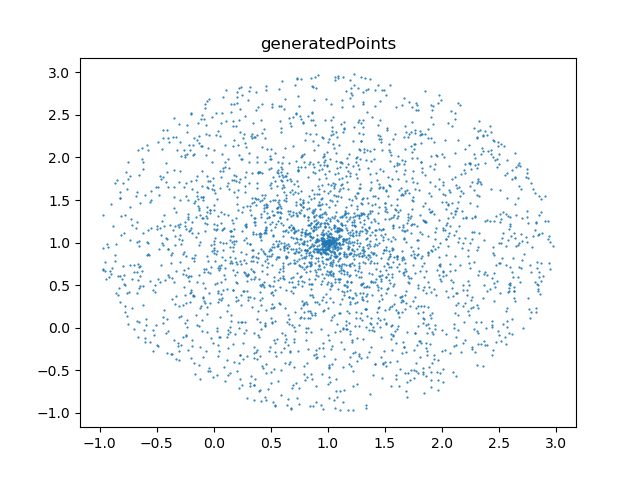

In [16]:
#plot generated points
fig1 = plt.figure()
ax1 = fig1.add_subplot(1,1,1)
ax1.set_title('generatedPoints')
ax1.scatter(spherePoints[:,0],spherePoints[:,1],s = 0.3)
plt.show()

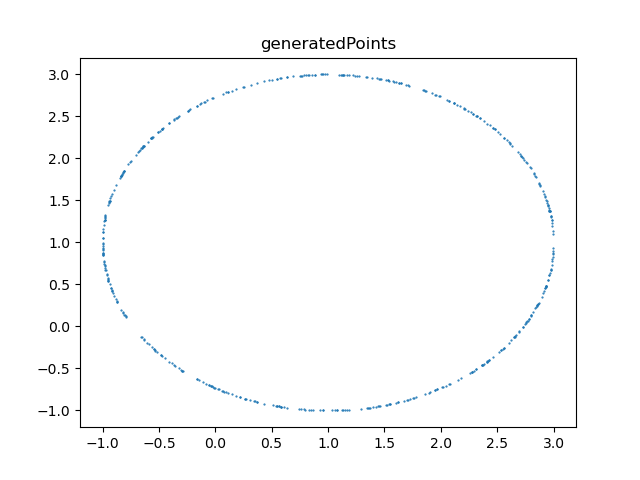

In [17]:
#plot generated points
fig1b = plt.figure()
ax1b = fig1b.add_subplot(1,1,1)
ax1b.set_title('generatedPoints')
ax1b.scatter(pointsOnBoundary[:,0],pointsOnBoundary[:,1],s = 0.3)
plt.show()

# Train NN with imposed BC

In [18]:
#define Trainingset, epochs, lr:
xy_grid = spherePoints
xy_grid.requires_grad = True
epochs = 1000
learningRate  = 1e-3

In [110]:
#define model:
solPDE = ImposedBCPINNSphere2D( 2000, 1)

In [121]:
#define optimizer
optimizer = torch.optim.Adam(solPDE.parameters(), lr = learningRate)

In [122]:
#computes initial loss to see where we start
loss, points = pinnLossPoissonSin(solPDE, xy_grid )
loss

tensor(12.8852, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [123]:
#training
for i in range(epochs):
  optimizer.zero_grad()
 
  loss,_ = pinnLossPoissonSin(solPDE, xy_grid )
  #if i%100 == 0:
  print(loss.item())
  loss.backward(retain_graph=True)
  optimizer.step()


12.885214499175808
29.486288105649788
13.357107050470804
22.836401023540976
12.697854930930092
10.988581039546213
10.070026753310085
7.092766090009331
6.7469638703951365
5.240026842754777
3.676502379533337
4.991070081635644
4.939924089626382
2.583865857966621
1.5490650153409828
2.502271004144206
2.1808927321957947
1.6243007236990799
1.8597287748936018
1.7376976985905919
1.0457797715004424
1.0295595900962433
1.3678060806834764
1.3813253067719027
1.0782857103971402
1.0300658669964662
1.1739857862170848
1.0938326655846002
0.8539518005497249
0.8403346252272087
0.9272348898010275
0.9417569985649286
0.8607449150218651
0.807164478209187
0.8592277186630134
0.8677712552318424
0.8384748427296647
0.7797069989628971
0.7609060829880683
0.8023868143602306
0.8147151662584431
0.7806882202262764
0.7555521194254986
0.7584943892205409
0.7681679322299894
0.7603360694083499
0.7406673187290004
0.7322752730522876
0.7415994244903444
0.7490929924031848
0.738996988946465
0.7187182999636382
0.7069916475840686
0.

KeyboardInterrupt: 

In [124]:
# Compute loss aftre training at single points
_,lossOnGrid = pinnLossPoissonSin(solPDE, xy_grid )

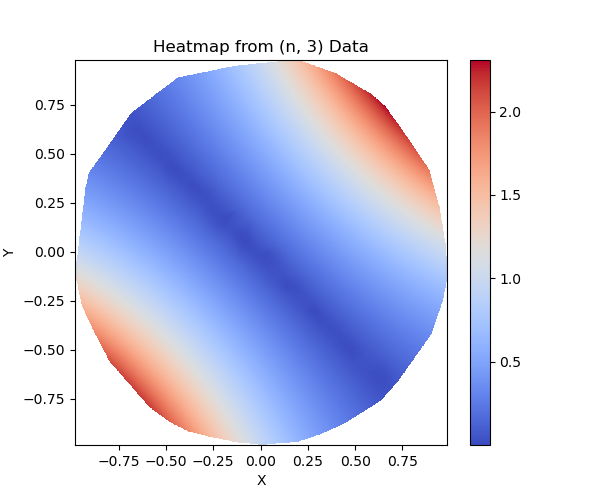

In [125]:
# Plot losses on training data points as heatmap

sampleSizeForDrawing = 1000
data = np.empty((sampleSizeForDrawing,3))
data[:,0] = xy_grid[:sampleSizeForDrawing,0].detach().numpy()
data[:,1] = xy_grid[:sampleSizeForDrawing,1].detach().numpy()
data[:,2] = lossOnGrid[:sampleSizeForDrawing].view(-1).detach().numpy()

# Create a meshgrid to interpolate over (choose grid resolution as needed)
grid_x, grid_y = np.mgrid[min(data[:, 0]):max(data[:, 0]):1000j, 
                          min(data[:, 1]):max(data[:, 1]):1000j]

# Interpolate the z values over the grid
grid_z = griddata((data[:, 0], data[:, 1]), data[:, 2], (grid_x, grid_y), method='cubic')



# Plot the heatmap
plt.figure(figsize=(6, 5))
plt.pcolormesh(grid_x, grid_y, grid_z, cmap='coolwarm', shading='auto')
plt.colorbar()  # Add colorbar to the side
plt.title("Heatmap from (n, 3) Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


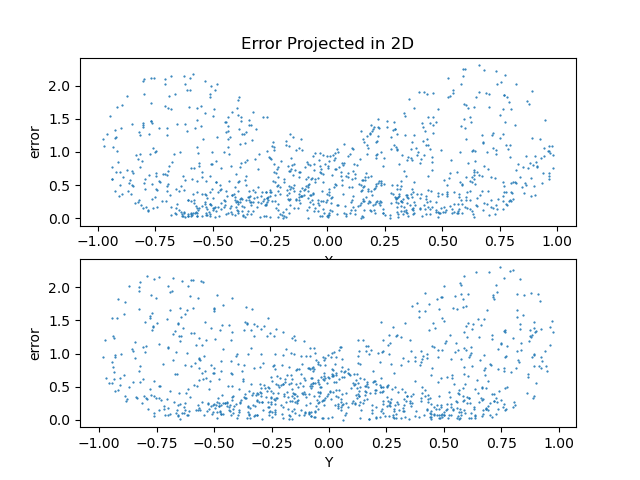

In [126]:
# Plot projected losses on xz and yz planes to see where "problems" happen

maxError = torch.inf
maskSmallerError = data[:,2]<maxError
fig5,ax5 = plt.subplots(2,1)#plt.figure()

ax5[0].set_title('Error Projected in 2D')
ax5[0].set_xlabel('X')
ax5[0].set_ylabel('error')


ax5[1].set_xlabel('Y')
ax5[1].set_ylabel('error')

ax5[0].scatter(data[maskSmallerError,0], data[maskSmallerError,2], s= 0.3)
ax5[1].scatter(data[maskSmallerError,1], data[maskSmallerError,2], s= 0.3)
plt.show()

C:\Users\seand\AppData\Local\Temp\ipykernel_6280\3022475823.py:22: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax6.scatter(x, y, z, cmap='viridis',c = 'blue')
C:\Users\seand\AppData\Local\Temp\ipykernel_6280\3022475823.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax6.scatter(x,y,ztrue, cmap = 'viridis', c = 'red' )


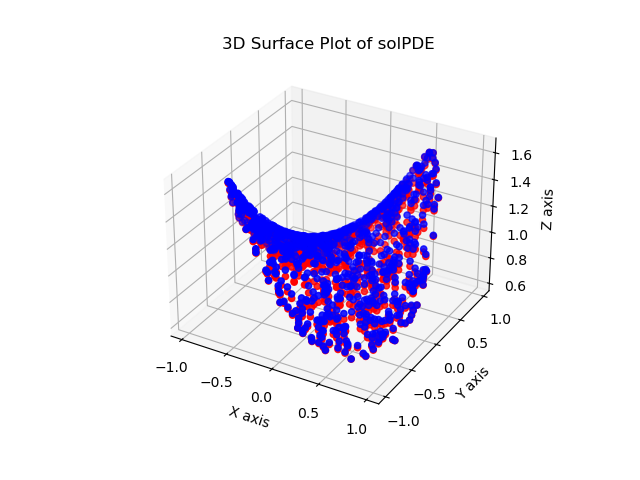

In [127]:
numPointsPlot = 1000
x = xy_grid[:numPointsPlot,0].view(-1).detach().numpy()
y = xy_grid[:numPointsPlot,1].view(-1).detach().numpy()
#X = x.tile((numPointsPlot,1)).detach().numpy()
#Y = y.view(-1,1).tile((1, numPointsPlot)).detach().numpy()
# Create a grid of x and y values
#x = np.linspace(0, 5, 5)
#y = np.linspace(0, 5, 5)
#X, Y = np.meshgrid(x, y)

ztrue = torch.exp( xy_grid[:numPointsPlot, 0] *xy_grid[:numPointsPlot, 1] ).view(-1).detach().numpy()


# Compute Z values using the function f(x, y)
z = solPDE(xy_grid[:numPointsPlot]).view(-1).detach().numpy()

# Create a 3D plot
fig6 = plt.figure()
ax6 = fig6.add_subplot(111, projection='3d')

# Plot the surface
ax6.scatter(x, y, z, cmap='viridis',c = 'blue')
ax6.scatter(x,y,ztrue, cmap = 'viridis', c = 'red' )

# Add labels and title
ax6.set_xlabel('X axis')
ax6.set_ylabel('Y axis')
ax6.set_zlabel('Z axis')
ax6.set_title('3D Surface Plot of solPDE')

# Show plot
plt.show()


there seems to be a sharp corner at y = 0

# Train NN without imposed BC

In [105]:
#define Trainingset, epochs, lr:
xy_grid = spherePoints
xy_grid.requires_grad = True
boundaryGrid = pointsOnBoundary
epochs = 100
learningRate  = 1e-2

In [106]:
#define model:
regularPINN = PINNModel( 1000, 3)

In [107]:
#define optimizer
optimizer = torch.optim.Adam(regularPINN.parameters(), lr = learningRate)

In [108]:
#computes initial loss to see where we start
loss, points = pinnLossPoissonSinWithBoundary(regularPINN, xy_grid, boundaryGrid )
loss

tensor(0.2482, dtype=torch.float64, grad_fn=<AddBackward0>)

In [109]:
#training
for i in range(epochs):
  optimizer.zero_grad()
 
  loss,_ = pinnLossPoissonSinWithBoundary(regularPINN, xy_grid , boundaryGrid, beta=1)
  #if i%100 == 0:
  print(loss.item())
  loss.backward(retain_graph=True)
  optimizer.step()


1.0549606846588286
28.45173839959032
2948.4316101348522
800.5110722127179
25.79853187947013
16.621707871601842
15.842794013369764
21.048884456530793
16.721916888206334
1.3737530538804328
17.266147777795723
17.22977730679124
1.414196666803643
11.085199347122867
1.101947369932908
10.40627237542838
4.0742738050609475
7.337407785148154
7.94482194075173
4.314634359904329
11.574395529890253
1.486966360571811
8.810618745878028
10.787106815609391
1.166552676099246
1.4029121469087167
18.759511300278614
5.795253099016234
37.46656968313129
45.02025616593257
20.305765141337883
34.0309121739544
50.98081447664614
34.3273956788011
12.908296053959539
23.25914939285907
1.108798620452127
28.639428087304253
22.382007778196908
15.835846786215436
17.688104723252884
13.10868605334286
8.382868501492835
28.215917792843605
28.83433000403634
2.8125041416919787
1.2824456246498408
11.987389282604415
8.697405552016392
5.128107448285386
14.791503976164332
1.0996823336156252
21.051494584050545
8.41937703407172
35.00

In [110]:
# Compute loss aftre training at single points
laplacian_u = laplacian(regularPINN, xy_grid)
lossOnGrid = torch.abs(laplacian_u - torch.sin(xy_grid[:,0] * xy_grid[:, 1]).view(-1,1))

lossOnBoundary = torch.abs(regularPINN(boundaryGrid) - (boundaryGrid[:,0] + boundaryGrid[:,1]).view(-1,1))

totalGrid = torch.cat((xy_grid, boundaryGrid), 0)
allLoss = torch.cat((lossOnGrid, lossOnBoundary),0).view(-1)



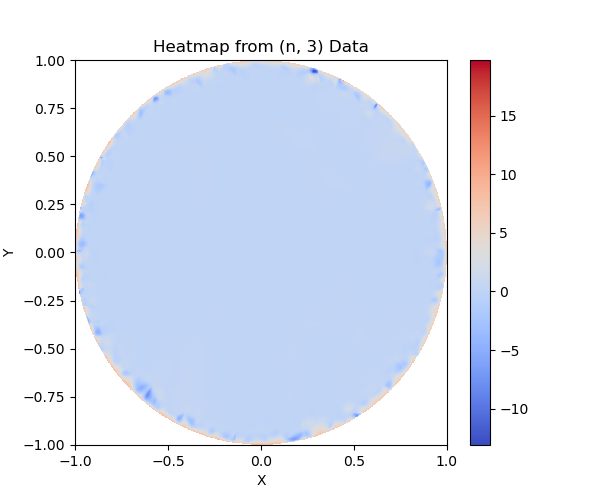

In [111]:
# Plot losses on training data points as heatmap

sampleSizeForDrawing = 3000
pickMask = torch.randint(0,allLoss.shape[0], (sampleSizeForDrawing,))
data = np.empty((sampleSizeForDrawing,3))
data[:,0] = totalGrid[pickMask,0].detach().numpy()
data[:,1] = totalGrid[pickMask,1].detach().numpy()
data[:,2] = allLoss[pickMask].view(-1).detach().numpy()

# Create a meshgrid to interpolate over (choose grid resolution as needed)
grid_x, grid_y = np.mgrid[min(data[:, 0]):max(data[:, 0]):1000j, 
                          min(data[:, 1]):max(data[:, 1]):1000j]

# Interpolate the z values over the grid
grid_z = griddata((data[:, 0], data[:, 1]), data[:, 2], (grid_x, grid_y), method='cubic')



# Plot the heatmap
plt.figure(figsize=(6, 5))
plt.pcolormesh(grid_x, grid_y, grid_z, cmap='coolwarm', shading='auto')
plt.colorbar()  # Add colorbar to the side
plt.title("Heatmap from (n, 3) Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

C:\Users\seand\AppData\Local\Temp\ipykernel_15756\1868684707.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax6.scatter(x, y, z1, cmap='viridis',c = 'blue')
C:\Users\seand\AppData\Local\Temp\ipykernel_15756\1868684707.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax6.scatter(x, y, z2, cmap='viridis',c = 'red')


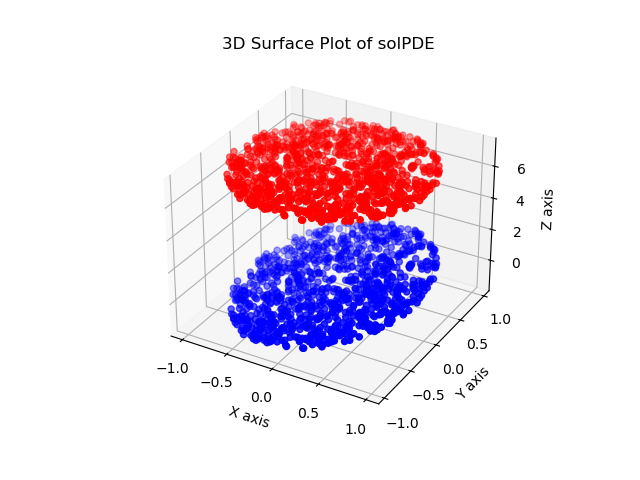

In [112]:
numPointsPlot = 1000
x = xy_grid[:numPointsPlot,0].view(-1).detach().numpy()
y = xy_grid[:numPointsPlot,1].view(-1).detach().numpy()
#X = x.tile((numPointsPlot,1)).detach().numpy()
#Y = y.view(-1,1).tile((1, numPointsPlot)).detach().numpy()
# Create a grid of x and y values
#x = np.linspace(0, 5, 5)
#y = np.linspace(0, 5, 5)
#X, Y = np.meshgrid(x, y)

# Compute Z values using the function f(x, y)
z1 = solPDE(xy_grid[:numPointsPlot]).view(-1).detach().numpy()
z2 = regularPINN(xy_grid[:numPointsPlot]).view(-1).detach().numpy()

# Create a 3D plot
fig6 = plt.figure()
ax6 = fig6.add_subplot(111, projection='3d')

# Plot the surface
ax6.scatter(x, y, z1, cmap='viridis',c = 'blue')
ax6.scatter(x, y, z2, cmap='viridis',c = 'red')

# Add labels and title
ax6.set_xlabel('X axis')
ax6.set_ylabel('Y axis')
ax6.set_zlabel('Z axis')
ax6.set_title('3D Surface Plot of solPDE')

# Show plot
plt.show( )


In [1]:
import torch